In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import set_config
set_config(transform_output = "pandas")

# Frame the Problem and Look at the Big Picture

1. Define the objective in business terms.
- Enhance risk management by implementing a predictive model that accurately determines the likelihood of a loan applicant defaulting. This model aims to reduce financial losses by enabling proactive decision-making on loan applications.

2. How will your solution be used?
- The predictive model will be integrated into the existing loan approval system to augment decision-making. When an application is received, the system will use the model to assess risk and suggest actions (approve, reject, or suggest modified loan terms). This assists loan officers by providing a data-driven risk assessment, which complements their expertise.

3. What are the current solutions/workarounds (if any)?
- Current solutions include manual assessment based on credit scores and financial ratios. These methods rely heavily on loan officers' subjective judgment and might not consistently capture all risk factors, especially those subtle patterns identifiable only through data analysis

4. How should you frame this problem (supervised/unsupervised, online/offline, ...)?
-This problem is best framed as a supervised binary classification task where each application is labeled as 'default' or 'no default.' The model will operate offline, with periodic updates to incorporate new data and trends, ensuring that the model remains current and effective.

5. How should performance be measured? Is the performance measure aligned with the business objective?
- The key performance metrics will be precision and recall, particularly focusing on minimizing false negatives (approving high-risk applications). The business objective is to reduce defaults, so prioritizing recall (sensitivity) might be essential to capture as many potential defaults as possible, even at the expense of some false positives.

6. What would be the minimum performance needed to reach the business objective?
- The model should achieve at least a 20% improvement in identifying potential defaults over current methods, which would substantively decrease financial losses due to defaults.

7. What are comparable problems? Can you reuse experience or tools?
- This problem shares similarities with credit card fraud detection where anomaly detection and classification methods are used. Techniques and insights from churn prediction models, which also categorize customers based on behavior, can be applied, especially in feature engineering and threshold tuning for classifications.

8. Is human expertise available?
- Yes, loan officers and financial analysts 

9. How would you solve the problem manually?
- Manually, loan officers review applications based on credit reports, repayment history, and financial statements, making decisions based on guidelines that might not dynamically adjust to changing economic conditions or new patterns of default.

10. List the assumptions you (or others) have made so far. Verify assumptions if possible.
- We assume that the historical data on defaults is indicative of future trends and that the selected features sufficiently capture the risk factors associated with defaults. These assumptions will be validated through continuous performance monitoring and feedback from loan officers on the ground.

# Get the Data

1. List the data you need and how much you need
- Anonymised Loan Default data for predicting if a loan will default or not

2. Find and document where you can get that data
- https://www.kaggle.com/datasets/joebeachcapital/loan-default/data

3. Get access authorizations

4. Create a workspace (with enough storage space)

5. Get the data

6. Convert the data to a format you can easily manipulate (without changing the data itself)

7. Ensure sensitive information is deleted or protected (e.g. anonymized)

8. Check the size and type of data (time series, geographical, ...). 

    Size of Data
    - 38,480 rows x 37 columns

    Type of Data
    - float64(19), int64(4), object(14)

    Is it a time series?
    - No

    Are any of the features unusable for the business problem?
    - Maybe the ID column, but other than that, no.

    Which feature(s) will be used as the target/label for the business problem? (including which are required to derive the correct label)
    - repay_fail

    Should any of the features be stratified during the train/test split to avoid sampling biases?
    - Based on the distribution, we should stratify to maintain the target variable's distribution.

9. Sample a test set, put it aside, and never look at it (no data snooping!)

In [3]:
# Load the dataset
file_path = 'Anonymize_Loan_Default_data.csv'  # Replace with your actual file path
try:
    # Attempt to load with default encoding
    Loan_Data = pd.read_csv(file_path)
except UnicodeDecodeError:
    # Fallback to other common encodings if there's an issue
    Loan_Data = pd.read_csv(file_path, encoding='latin1')


In [4]:
Loan_Data.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'repay_fail'],
      dtype='object')

In [5]:
Loan_Data.size

1423760

In [6]:
Loan_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38480 entries, 0 to 38479
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              38480 non-null  int64  
 1   id                      38480 non-null  int64  
 2   member_id               38480 non-null  int64  
 3   loan_amnt               38479 non-null  float64
 4   funded_amnt             38479 non-null  float64
 5   funded_amnt_inv         38479 non-null  float64
 6   term                    38480 non-null  object 
 7   int_rate                38480 non-null  float64
 8   installment             38479 non-null  float64
 9   emp_length              37487 non-null  object 
 10  home_ownership          38480 non-null  object 
 11  annual_inc              38478 non-null  float64
 12  verification_status     38480 non-null  object 
 13  issue_d                 38480 non-null  object 
 14  loan_status             38480 non-null

In [7]:
Loan_Data.head

<bound method NDFrame.head of        Unnamed: 0       id  member_id  loan_amnt  funded_amnt  \
0               2        2          2        0.0          0.0   
1               3   545583     703644     2500.0       2500.0   
2               4   532101     687836     5000.0       5000.0   
3               5   877788    1092507     7000.0       7000.0   
4               6   875406    1089981     2000.0       2000.0   
...           ...      ...        ...        ...          ...   
38475       38476   849205    1060907     3000.0       3000.0   
38476       38477   852914    1065048    10400.0      10400.0   
38477       38478   519553     671637    16000.0      10550.0   
38478       38479   825638    1034448    10000.0      10000.0   
38479       38480  1029847    1249126     3200.0       3200.0   

       funded_amnt_inv       term  int_rate  installment emp_length  ...  \
0              0.00000  36 months      0.00         0.00   < 1 year  ...   
1           2500.00000  36 months    

In [8]:
Loan_Data.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,...,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,repay_fail
count,38480.000000,3.848000e+04,3.848000e+04,38479.000000,38479.000000,38479.000000,38480.00000,38479.000000,3.847800e+04,38480.000000,...,38479.000000,38479.000000,3.847600e+04,38479.000000,38479.000000,38479.000000,38479.000000,38479.000000,38479.000000,38480.000000
mean,19240.500000,6.649979e+05,8.261899e+05,11094.727644,10831.856337,10150.141518,12.16430,323.163255,6.899531e+04,13.378119,...,9.342966,0.057902,1.428987e+04,22.108501,11980.696892,11274.519569,9646.412705,2232.768235,2614.441757,0.151481
std,11108.363516,2.192322e+05,2.793531e+05,7405.416042,7146.853682,7128.026828,3.73744,209.089097,6.447639e+04,6.744356,...,4.498075,0.245707,2.194138e+04,11.588602,9006.505205,8946.229941,7051.828302,2570.177312,4391.969583,0.358522
min,1.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9620.750000,4.983645e+05,6.384620e+05,5200.000000,5100.000000,4950.000000,9.62000,165.740000,4.000000e+04,8.200000,...,6.000000,0.000000,3.639750e+03,13.000000,5463.099238,4811.735000,4400.000000,657.700000,212.010000,0.000000
50%,19240.500000,6.443195e+05,8.242545e+05,9750.000000,9600.000000,8495.792749,11.99000,277.980000,5.865000e+04,13.485000,...,9.000000,0.000000,8.839500e+03,20.000000,9673.221341,8953.240000,8000.000000,1335.090000,526.000000,0.000000
75%,28860.250000,8.265608e+05,1.034706e+06,15000.000000,15000.000000,14000.000000,14.72000,429.350000,8.200000e+04,18.690000,...,12.000000,0.000000,1.726550e+04,29.000000,16402.394995,15486.925000,13315.100000,2795.020000,3169.815000,0.000000
max,38480.000000,1.077430e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,100.99000,1305.190000,6.000000e+06,100.000000,...,47.000000,5.000000,1.207359e+06,90.000000,58563.679930,58563.680000,35000.020000,23611.100000,36115.200000,1.000000


In [9]:
Loan_Data.isnull().sum()

Unnamed: 0                    0
id                            0
member_id                     0
loan_amnt                     1
funded_amnt                   1
funded_amnt_inv               1
term                          0
int_rate                      0
installment                   1
emp_length                  993
home_ownership                0
annual_inc                    2
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   1
earliest_cr_line              0
inq_last_6mths                1
mths_since_last_delinq    24363
open_acc                      1
pub_rec                       1
revol_bal                     4
revol_util                   59
total_acc                     1
total_pymnt                   1
total_pymnt_inv               1
total_rec_prncp               1
total_re

In [10]:
Loan_Data.duplicated().sum()

np.int64(0)

In [11]:
target_column = 'repay_fail' 
Loan_Data[target_column].value_counts(normalize=True)

repay_fail
0    0.848519
1    0.151481
Name: proportion, dtype: float64

In [12]:
# Split the data into a training and test set (optional)
train_set = Loan_Data.sample(frac=0.8, random_state=42)  # 80% for training
test_set = Loan_Data.drop(train_set.index)  # Remaining 20% for testing

Explore the Data
================


1. Copy the data for exploration, downsampling to a manageable size if necessary.

2. Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...)

3. For supervised learning tasks, identify the target attribute(s)

4. Visualize the data

5. Study the correlations between attributes

6. Study how you would solve the problem manually


7. Identify the promising transformations you may want to apply

8. Identify extra data that would be useful (go back to “Get the Data”)



| Name                   | Type            | Noise | Distribution                                                                   | Missing Values  |
|------------------------|-----------------|-------|--------------------------------------------------------------------------------|-----------------|
| id                     | Numerical       | maybe | muti-modal                                                                     | no              |
| member_id              | Numerical       | no    | multi-modal                                                                    | no              |
| loan_amnt              | Numerical       | no    | multi-modal                                                                    | no              |
| funded_amnt            | Numerical       | no    | multimodal                                                                     | no              |
| funded_amnt_inv        | Float/Numerical | no    | multimodal                                                                     | no              |
| term                   | Numerical       | no    | 36 months 74%  60 months 26%                                                   | no              |
| int_rate               | float           | no    | Unimodal                                                                       | no              |
| installment            | float           | no    | right skewed                                                                   | no              |
| emp_length             | object          | no    | 10+ years 22%  < 1 year 12%  Other (25450) 66%                                 | no              |
| home_ownership         | String          | no    | RENT 47%  MORTGAGE 45%  Other (3087) 8%                                        | no              |
| annual_inc             | float           |       | right skewed                                                                   | no              |
| verification_status    | String          | no    | Not Verified 44%  Verified 32%  Other (9348) 24%                               | no              |
| issue_d                | Object          | no    | Nov-11 5%  Dec-11 5%  Other (34356) 89%                                        | no              |
| loan_status            | String          | no    | Fully Paid 78%  Charged Off 13%  Other (3382) 9%                               | no              |
| purpose                | String          | no    | debt_consolidation 47%  credit_card 13%  Other (15589) 41%                     | no              |
| zip_code               | object          | no    | 100xx 1%  945xx 1%  Other (37405) 97%                                          | no              |
| addr_state             | String          | no    | CA 18%  NY 10%  Other (28024) 73%                                              | no              |
| # dti                  | float           | no    | normal                                                                         | no              |
| delinq_2yrs            | Numerical       | no    | skewed towards 0                                                               | no              |
| earliest_cr_line       | object          | maybe | 528 Unique values                                                              | no              |
| inq_last_6mths         | Numerical       | no    | highly skewed towards 0                                                        | no              |
| mths_since_last_delinq | Numerical       | no    | uniform decline from 0 up to around 20 months,  and then gradually tapers off. | yes             |
| open_acc               | Numerical       | no    | multimodal distribution                                                        | yes             |
| pub_rec                | Numerical       | no    | 0 94%  1 5%  Other (72) 0%                                                     | no              |
| revol_bal              | Numerical       | no    | distribution sharply decreasing after a certain point                          | no              |
| revol_util             | Float object    | no    | 0% 2%  0.10% 0%  Other (37471) 97%                                             | no              |
| total_acc              | Numerical       | no    | right skewed                                                                   | no              |
| total_pymnt            | float           | no    | right skewed                                                                   | no              |
| total_pymnt_inv        | float           | no    | right skewed                                                                   | no              |
| total_rec_prncp        | Numerical/float | no    | multimodal                                                                     | no              |
| total_rec_int          | Float           | no    | right skewed                                                                   | no              |
| last_pymnt_d           | Object          | no    | distribution gradually declines                                                | no              |
| last_pymnt_amnt        | float           | no    | right skewed                                                                   | no              |
| next_pymnt_d           | object          | no    | NA 91%  Jul-16 2%  Other (2474) 6%                                             | yes             |
| last_credit_pull_d     | object          |       | Jun-16 29%  Mar-16 3%  Other (26123) 68%                                       | no              |
| repay_fail             | Numerical       | no    |                                                                                | no              |

- potentially dropping colums: id, member_id 

- Normalize Loan Data by State: When analyzing addr_state, adjust for the number of loans or normalize data based on state population to prevent bias.

- Model Sensitivity to DTI: Given the importance of dti in loan performance, ensure your models can differentiate well across the spectrum of DTI values, particularly paying attention to higher DTIs.

- Imbalance Techniques for Delinquencies: Apply appropriate methods to manage the skewed distribution of delinq_2yrs to enhance model accuracy and predictiveness, especially if delinquency prediction is a goal.





In [13]:
Loan_Data_explore = Loan_Data.copy()

In [14]:
Loan_Data_explore.value_counts()

Unnamed: 0  id      member_id  loan_amnt  funded_amnt  funded_amnt_inv  term       int_rate  installment  emp_length  home_ownership  annual_inc  verification_status  issue_d  loan_status                                          purpose             zip_code  addr_state  dti    delinq_2yrs  earliest_cr_line  inq_last_6mths  mths_since_last_delinq  open_acc  pub_rec  revol_bal  revol_util  total_acc  total_pymnt   total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt_d  last_pymnt_amnt  next_pymnt_d  last_credit_pull_d  repay_fail
7           506439  652909     3600.0     3600.0       3600.000000      36 months  10.25     116.59       10+ years   MORTGAGE        675048.0    Not Verified         Apr-10   Does not meet the credit policy. Status:Fully Paid   other               352xx     AL          1.55   0.0          Apr-98            4.0             25.0                    8.0       0.0      0.0        0%          25.0       4206.031191   4206.03          3600.00          606.03   

In [16]:
Loan_Data['member_id'].value_counts()


member_id
2          1
130794     1
1253838    1
933746     1
623916     1
          ..
1228886    1
459091     1
500726     1
409569     1
1249126    1
Name: count, Length: 38480, dtype: int64

# Distributions

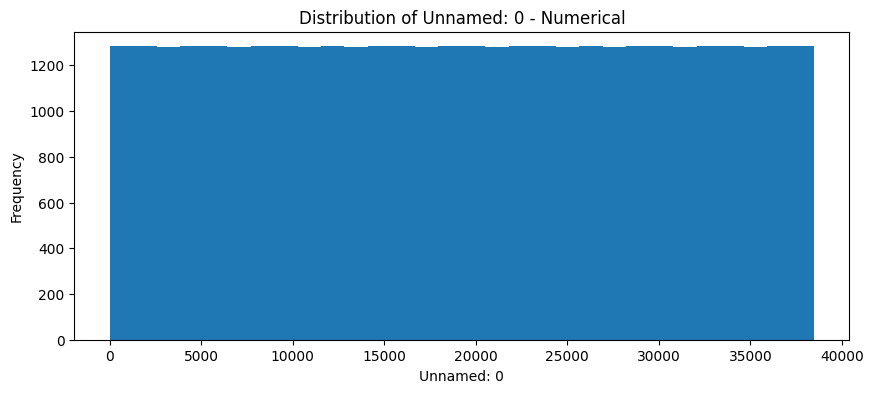

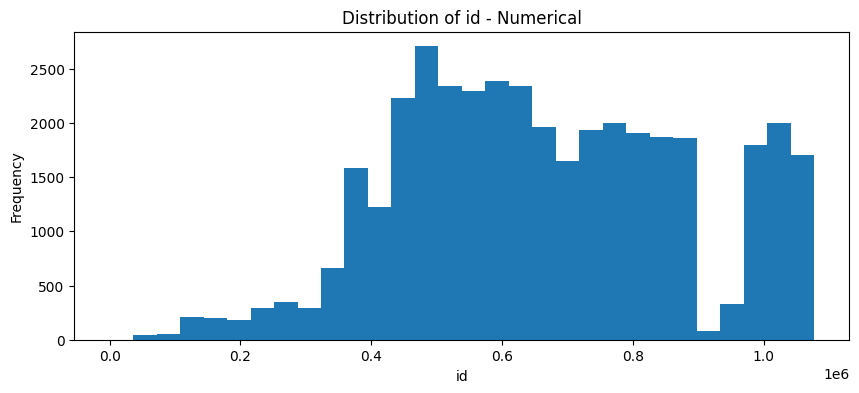

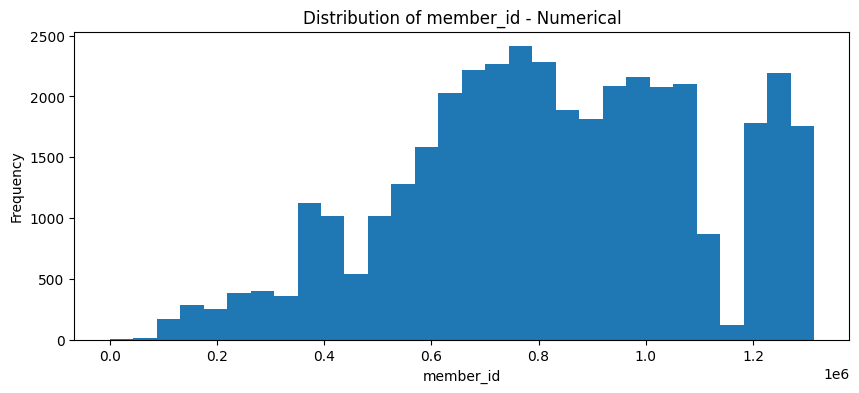

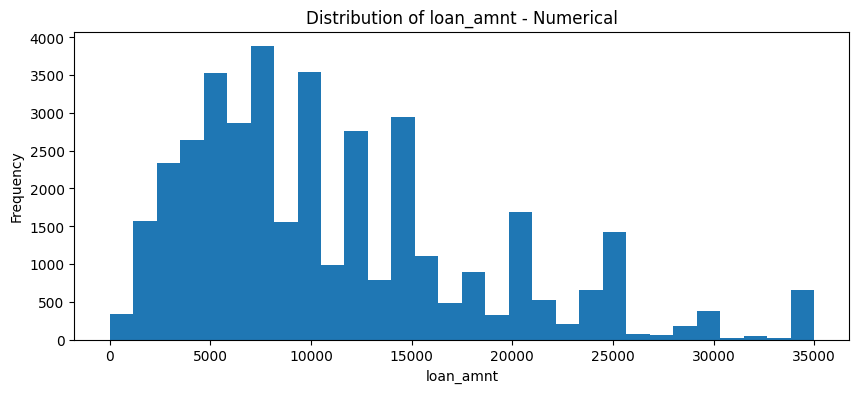

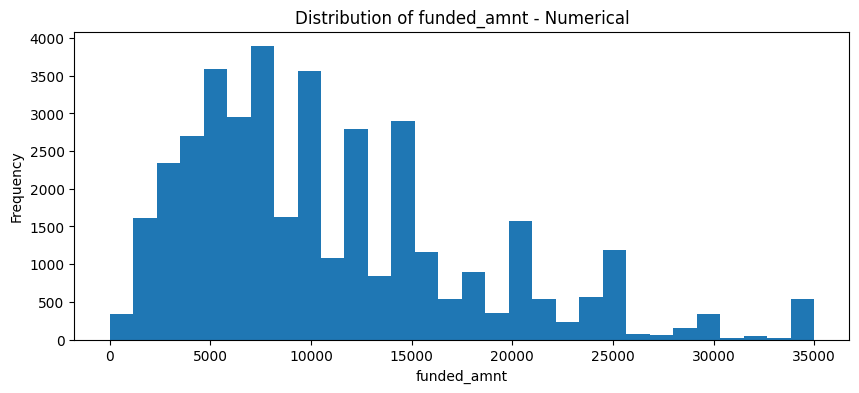

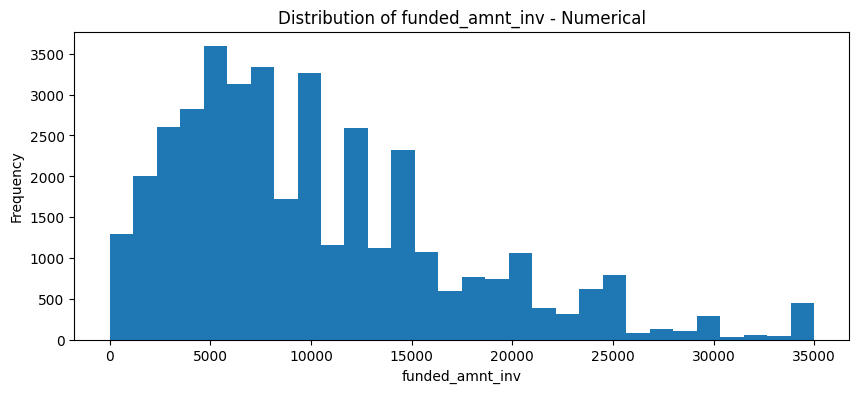

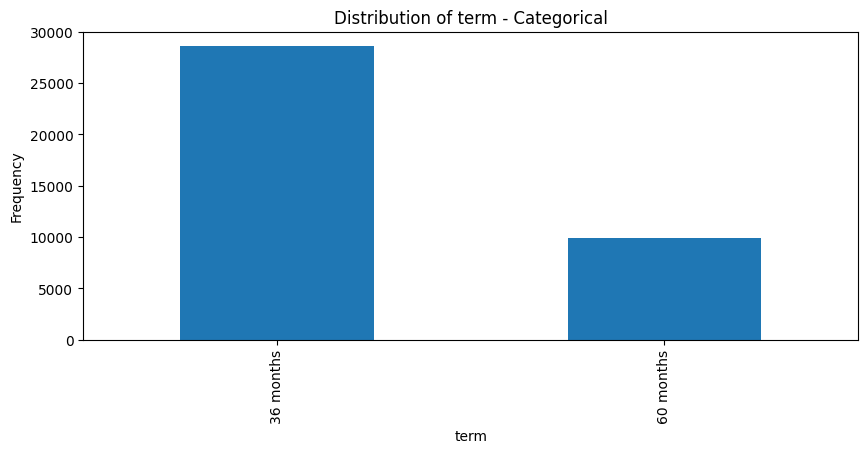

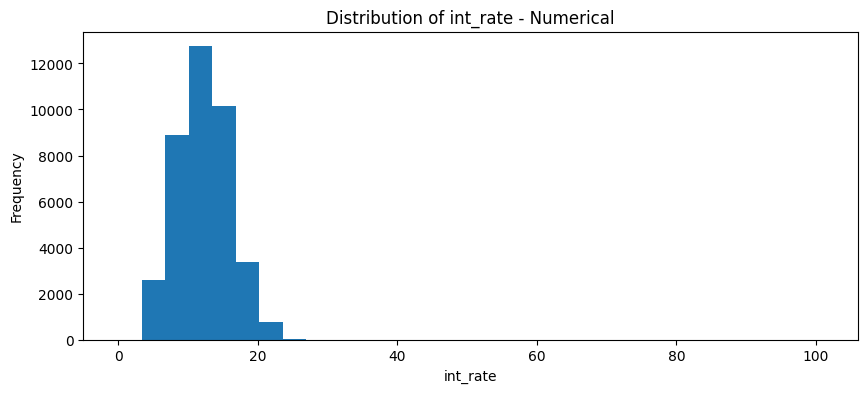

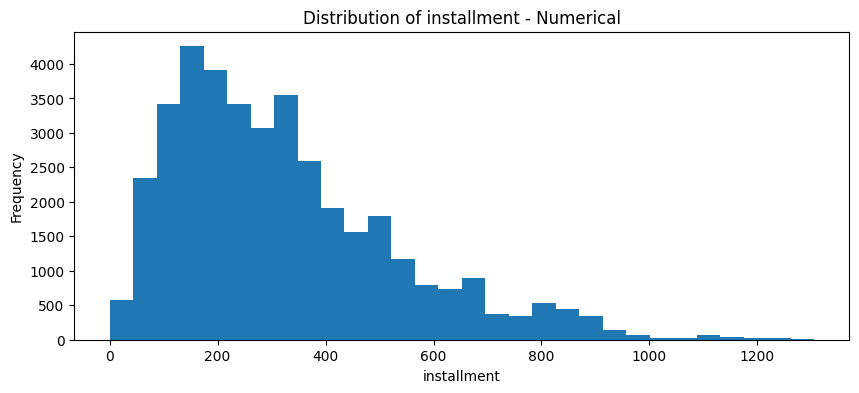

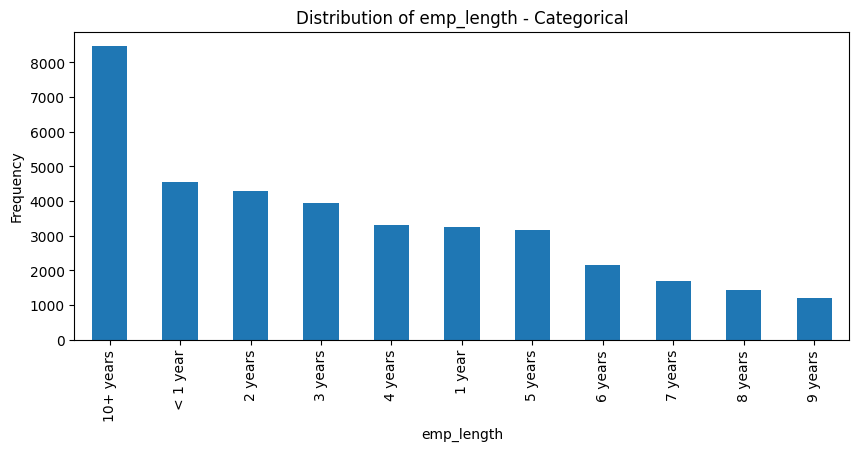

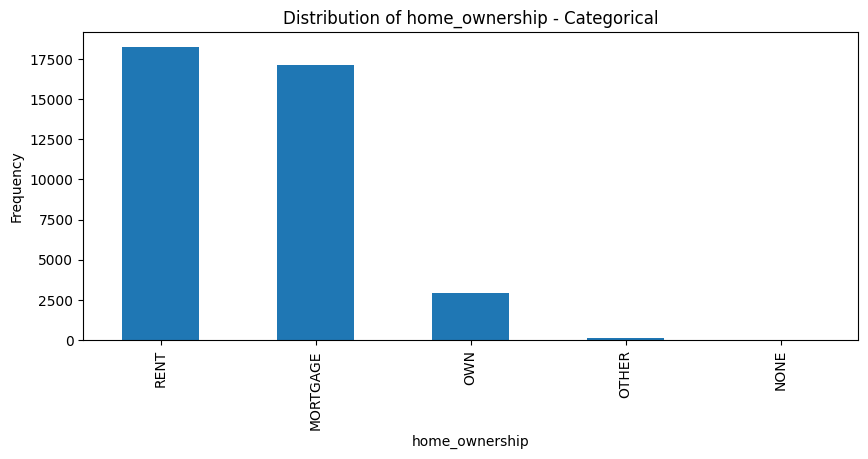

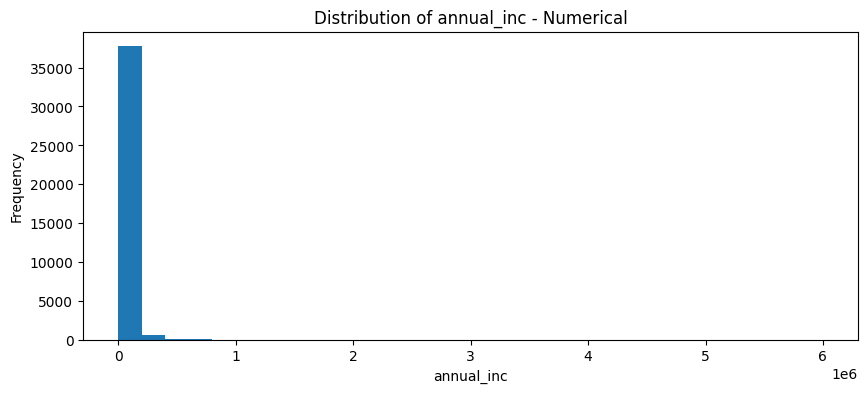

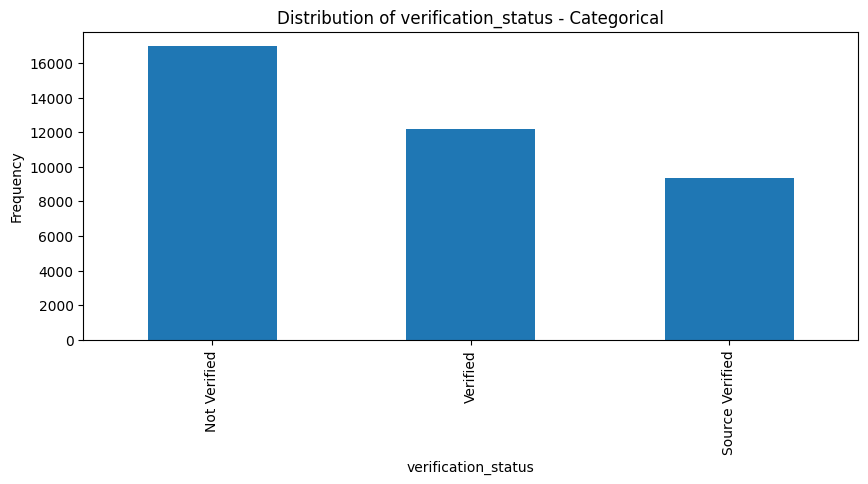

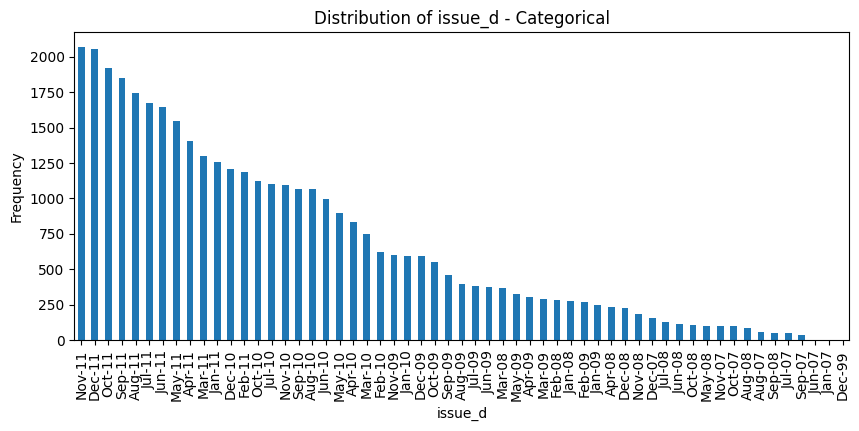

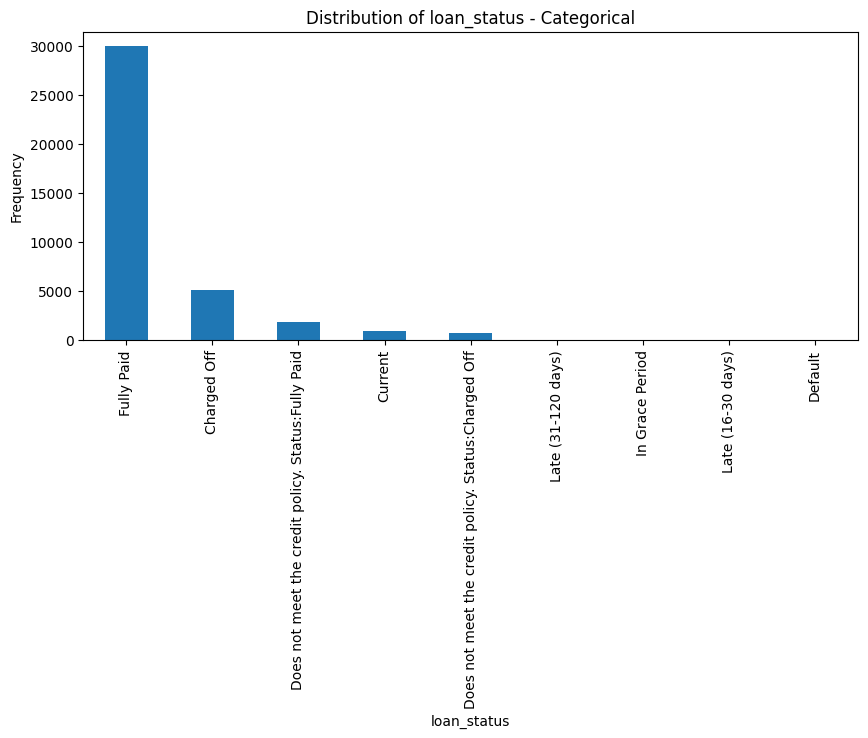

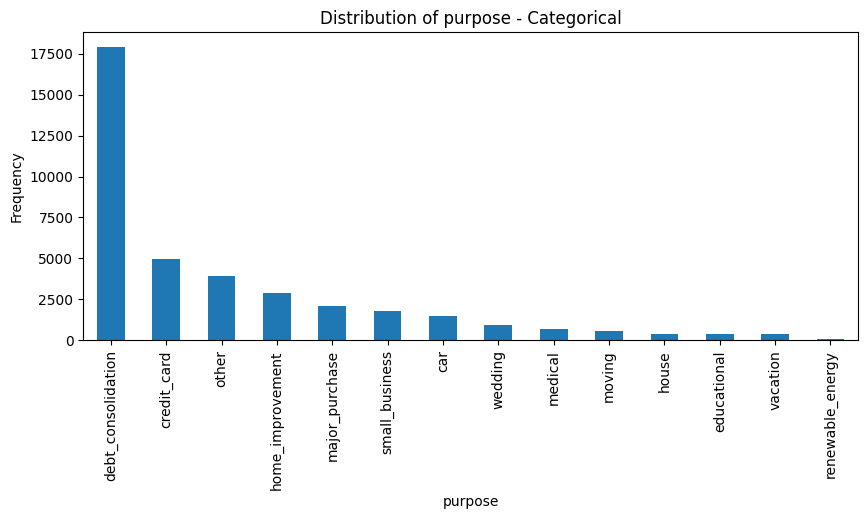

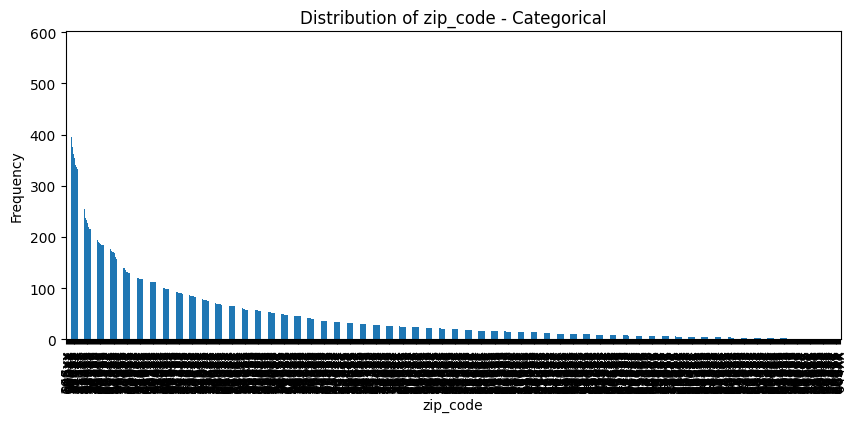

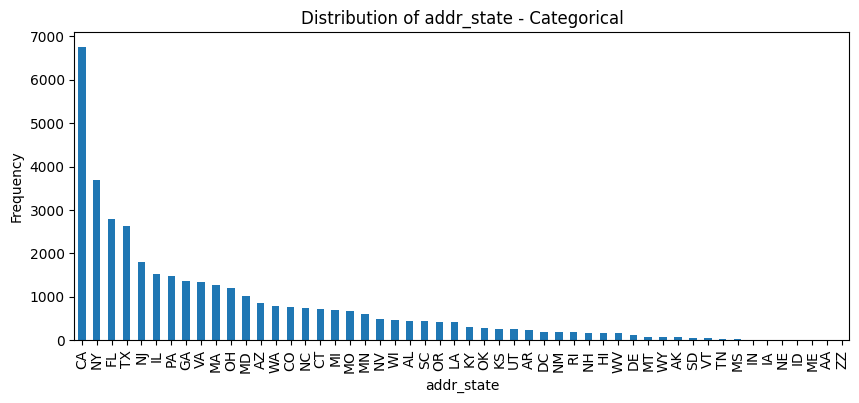

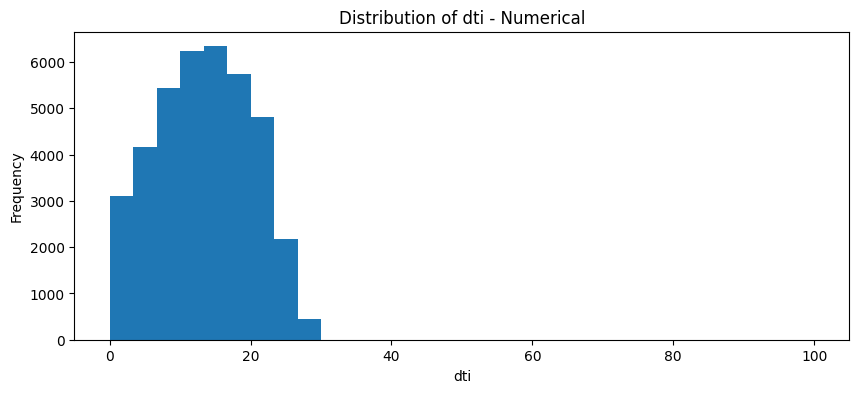

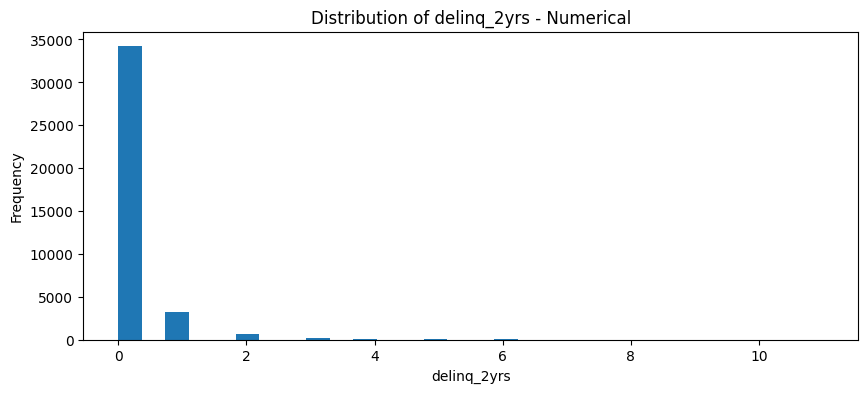

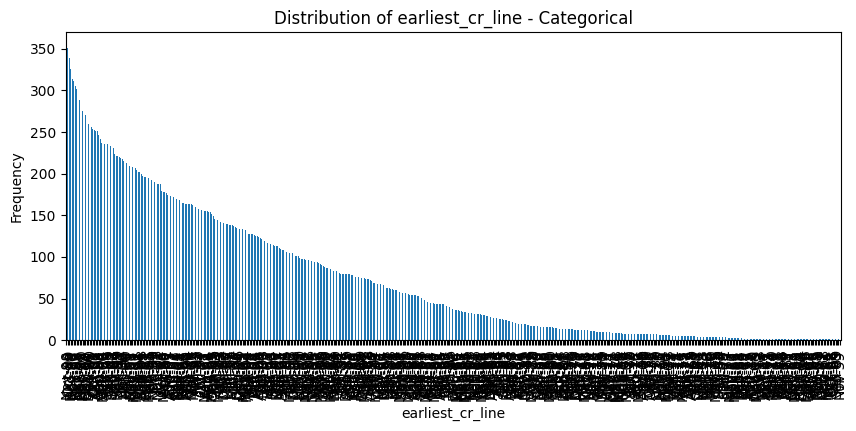

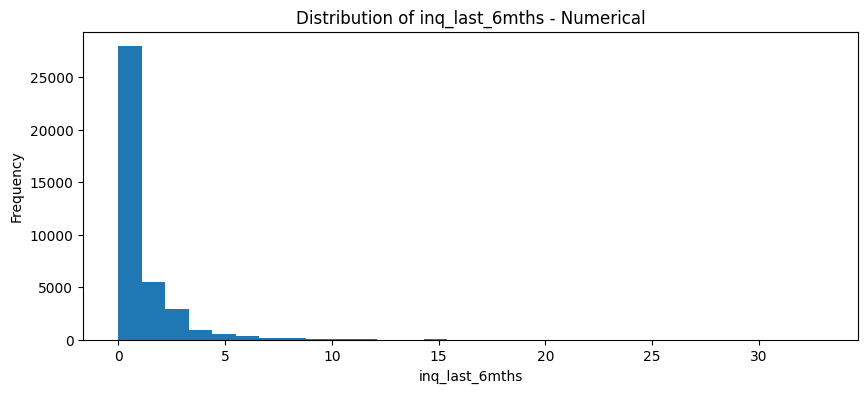

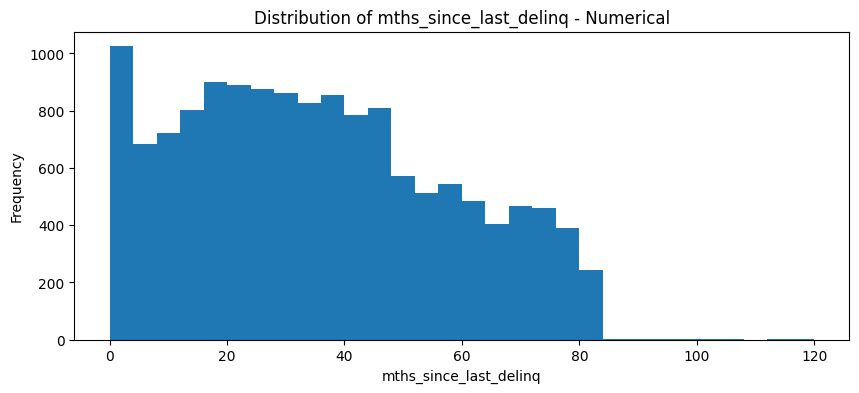

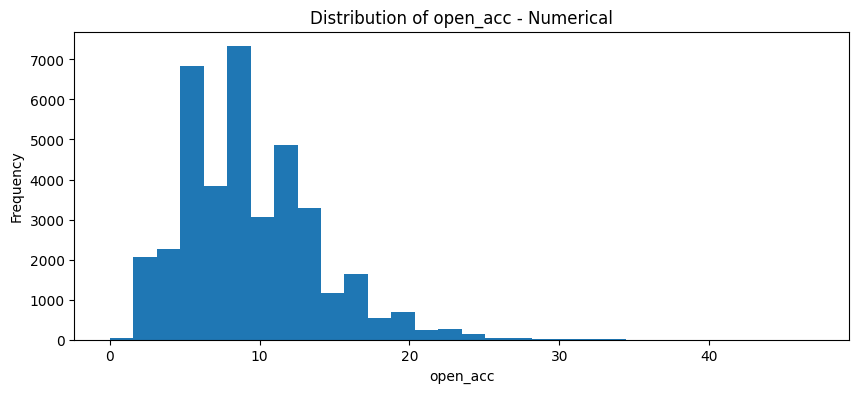

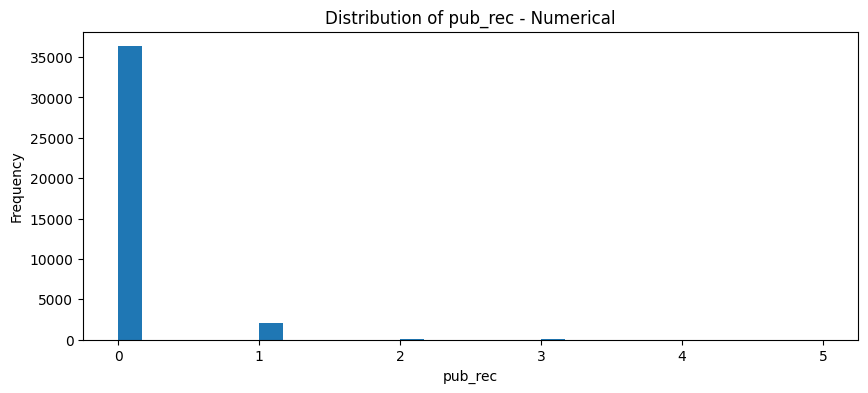

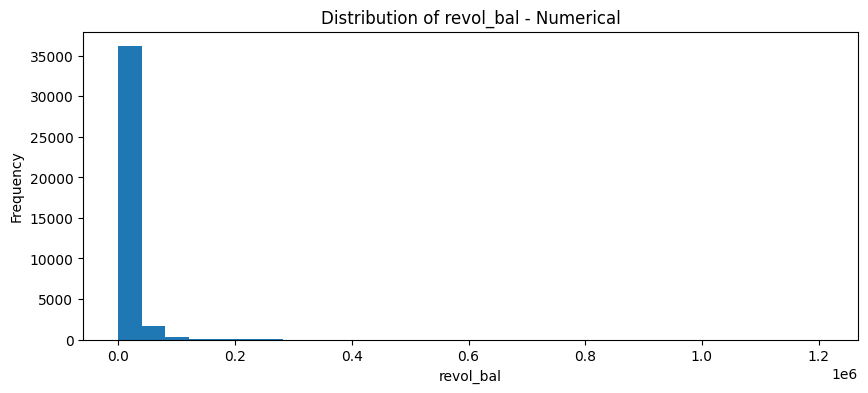

/Users/nelsont/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nelsont/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 148 (\x94) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


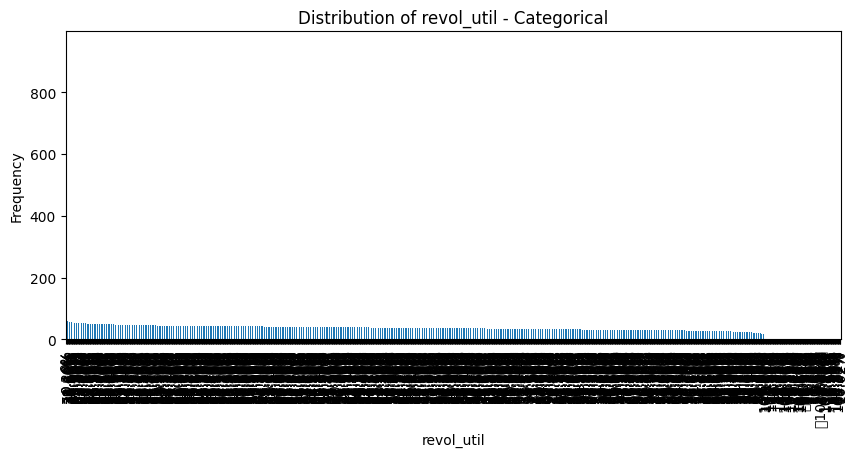

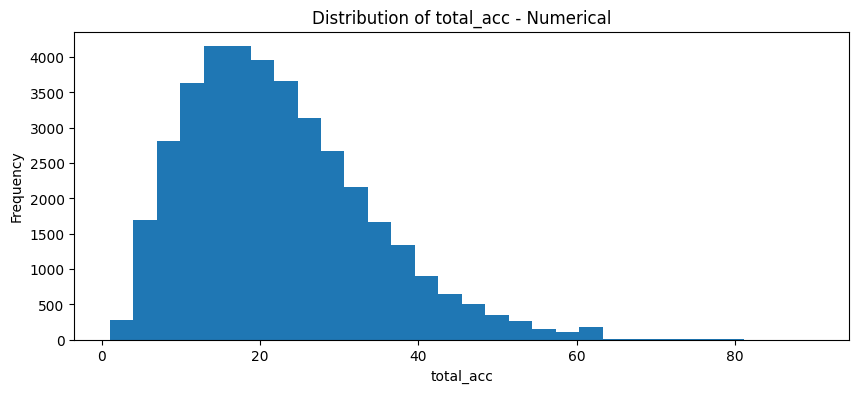

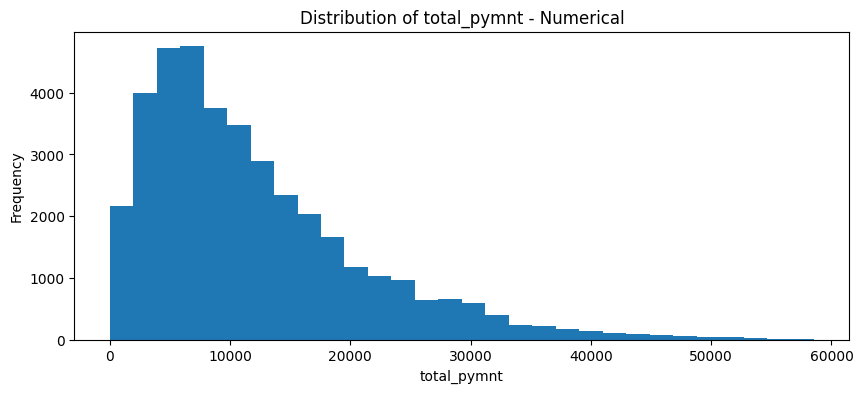

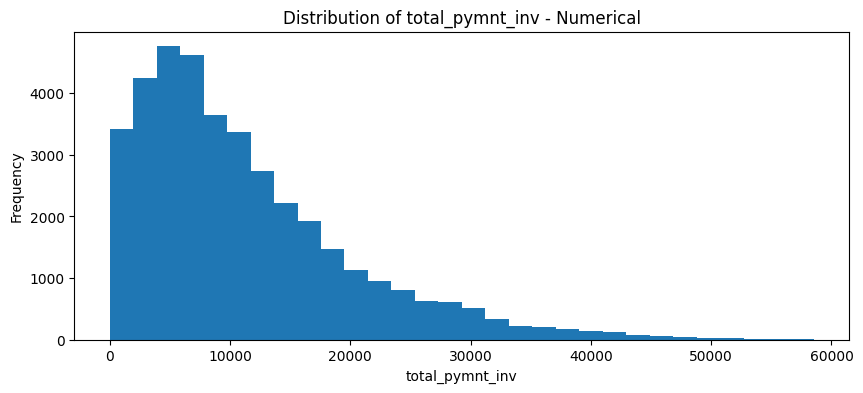

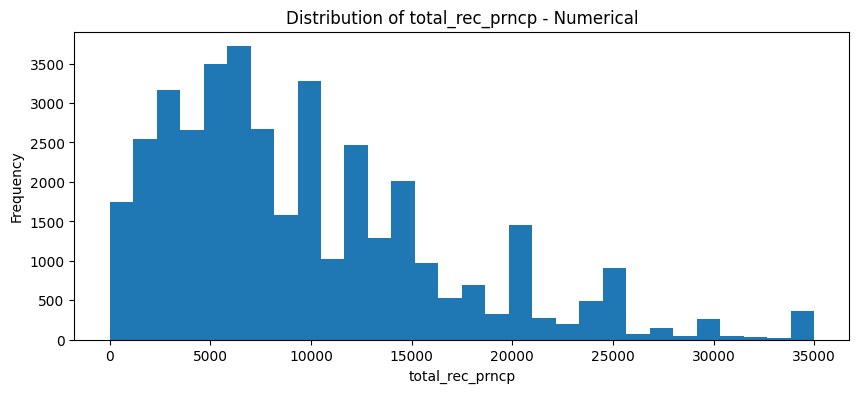

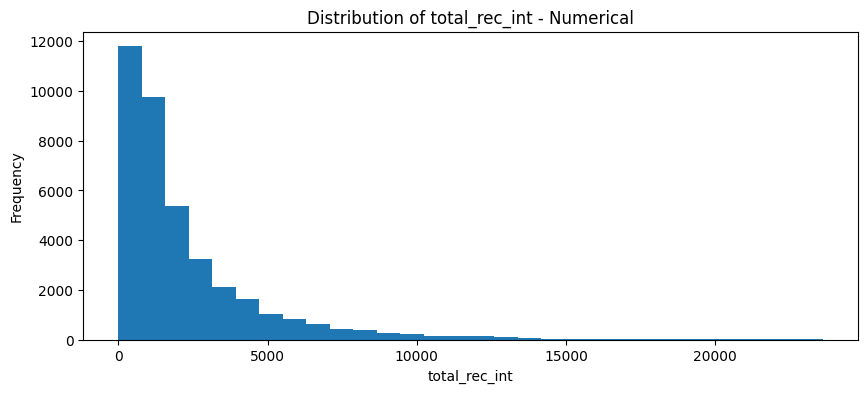

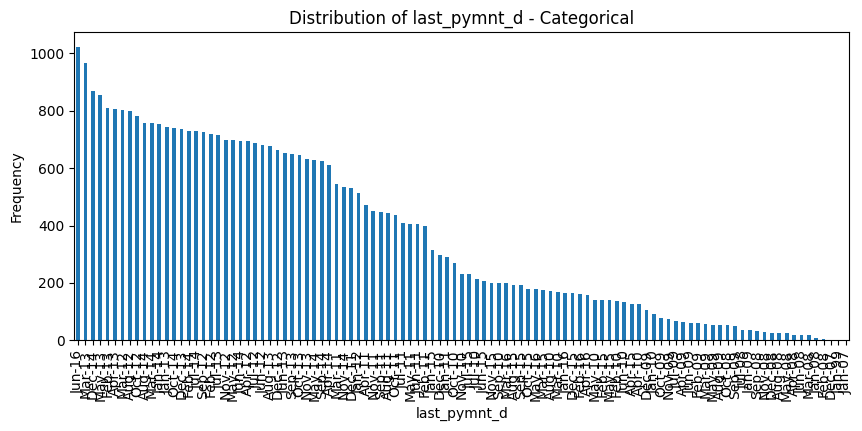

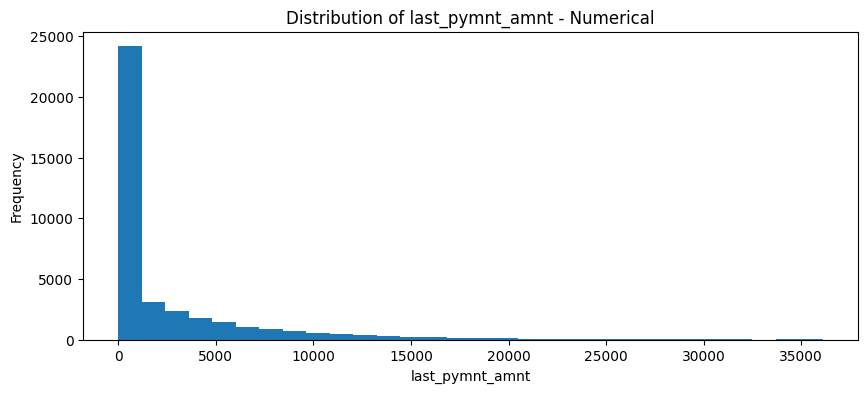

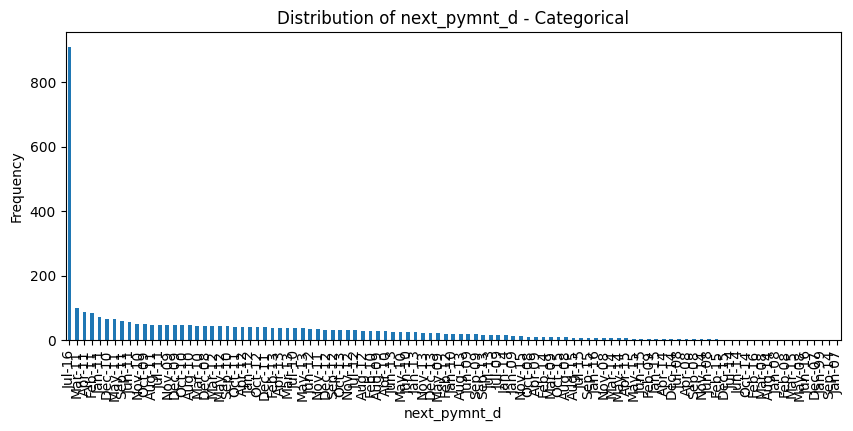

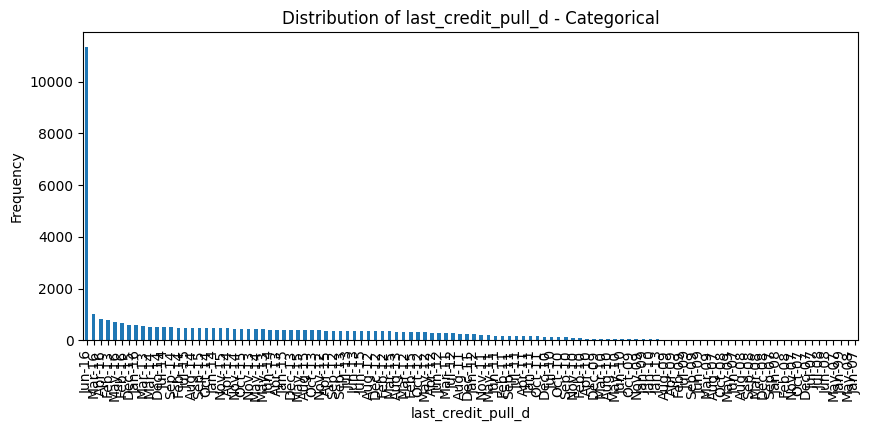

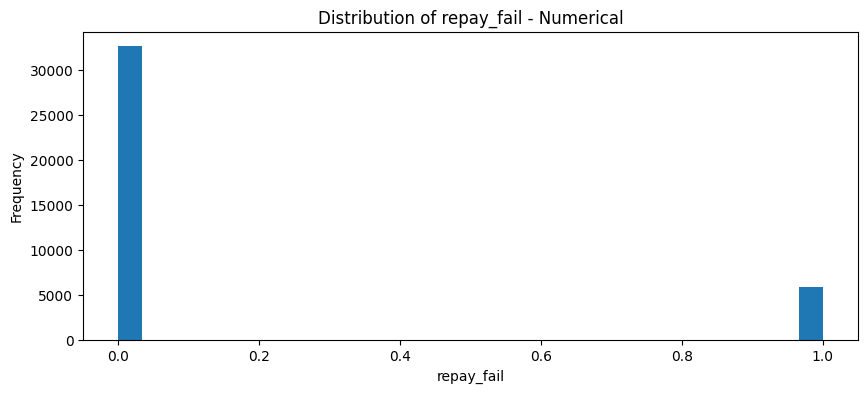

In [15]:
# Function to plot the distribution of each column
def plot_distributions(dataframe):
    for column in dataframe.columns:
        plt.figure(figsize=(10, 4))
        # Check data type of the column
        if dataframe[column].dtype == 'object':  # Categorical data
            # Use value_counts to see the distribution of categorical data
            value_count = dataframe[column].value_counts()
            value_count.plot(kind='bar')
            plt.title(f'Distribution of {column} - Categorical')
        else:  # Numerical data
            # Use histogram to see the distribution of numerical data
            dataframe[column].hist(bins=30)
            plt.title(f'Distribution of {column} - Numerical')
        plt.ylabel('Frequency')
        plt.xlabel(column)
        plt.grid(False)
        plt.show()

# Call the function with your dataframe
plot_distributions(Loan_Data_explore)
